![](https://i.imgur.com/eBRPvWB.png)

# PyTorch: Klasyfikacja nazwisk na poziomie znaków używając RNN

Będziemy budować i trenować klasyfikator RNN na poziomie znaku, aby klasyfikował całe słowa. RNN na poziomie znaku odczytuje słowa jako serię znaków - wyprowadzając prognozę i "stan ukryty" na każdym etapie, wprowadzając swój poprzedni stan ukryty do każdego kolejnego kroku. Ostateczną prognozę przyjmujemy jako wynik, tj. Do której klasy należy dane słowo.

Mówiąc dokładniej trening sieci przeprowadzimy na kilku tysiącach nazwisk z 18 języków pochodzenia aby przewidzieć język z którego nazwa pochodzi:

```
$ python predict.py Hinton
(-0.47) Scottish
(-1.52) English
(-3.57) Irish

$ python predict.py Schmidhuber
(-0.19) German
(-2.48) Czech
(-2.68) Dutch
```

# Polecane piśmiennictwo

Zakładam że jest już zainstalowany PyTorch, znasz Python'a, oraz znasz pojęcie Tensor'ów:

* http://pytorch.org/ - instalacja PyTorch
* [Deep Learning with PyTorch: A 60-minute Blitz](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) - Podstawy PyTorch
* [jcjohnson's PyTorch examples](https://github.com/jcjohnson/pytorch-examples) przykłady wykorzystania PyTorch
* [Introduction to PyTorch for former Torchies](https://github.com/pytorch/tutorials/blob/master/Introduction%20to%20PyTorch%20for%20former%20Torchies.ipynb) jeżeli znasz Lua

Trochę wiedzy o RNN:

* [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) przykłady z życia wzięte
* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) RNN i LSTM w pigułce

# Przygotowanie danych

Dane znajdują się w folderze `data/names` są podzilone na 18 plików tekstowych nazwanych wg schematu "[Language].txt". Każdy plik zawiara wiele nazwisk, po 1 w każdej linii w losowej kolejności. Wymagają konwersji z Unicode do ASCII.

Otrzymamy coś w rodzaju słownika składającego się z list nazwisk dla każdego z języków, `{language: [names ...]}`. A dokładniej generyczna zmienna "kategoria" oraz "linia" (dla języka i nazwiska w naszym przypadku) są używane dla zapewnienia przyszłej łatwej rozszeżalności.

In [1]:
import glob

all_filenames = glob.glob('data/names/*.txt')
print(all_filenames)

['data/names/Spanish.txt', 'data/names/Portuguese.txt', 'data/names/Chinese.txt', 'data/names/Dutch.txt', 'data/names/Italian.txt', 'data/names/Vietnamese.txt', 'data/names/Polish.txt', 'data/names/Greek.txt', 'data/names/Arabic.txt', 'data/names/English.txt', 'data/names/Korean.txt', 'data/names/Irish.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Japanese.txt', 'data/names/Scottish.txt', 'data/names/Czech.txt', 'data/names/German.txt']


In [2]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename).read().strip().split('\n')
    return lines

for filename in all_filenames:
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print('n_categories =', n_categories)

n_categories = 18


In [3]:
all_letters = ''.join(sorted(list(set(''.join([''.join(v) for k,v in category_lines.items()])))))
n_letters = len(all_letters)

print(f'all_letters = {all_letters}')
print(f'n_letters = {n_letters}')

all_letters =  ',-/1:ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz ÁÉßàáãäçèéêìíñòóõöùúüąłńŚŻż
n_letters = 87


Teraz mamy "category_lines", słownik mapujący każdą kategorię (język) do listy nazwisk. Przechowujemy także "all_categories" (po prostu lsitę języków) oraz "n_categories" dla przyszłego użytku.

In [4]:
c = category_lines['Polish']; print(len(c))
print(c[:5])

139
['Adamczak', 'Adamczyk', 'Andrysiak', 'Auttenberg', 'Bartosz']


# Konwersja nazwisk na Tensory

Teraz jak już wszystkie nazwiska są zorganizowane musimy je przekonwertować na Tensory.

Do preprezentacji pojedynczej litery używamy metody "one-hot vector" rozmiaru <1 x n_letters>. One-hot vector jest wypełniony 0 za wyjątkiem 1 znajdującej w miejscu przynależnym do pożądanej litery np. `"b" = <0 1 0 0 0 ...>`.

Aby zbudować słowo łączymy kilka takich wektorów w pojedynczą macież o wymiarach: `<line_length x 1 x n_letters>`.

Dodatkowy wymiar oznaczony 1 jest potrzebny ponieważ PyTorch zakłada że wszystko jest ładowane w batchach - my deklarujemy rozmiar batchu równy 1.


In [5]:
import torch

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    letter_index = all_letters.find(letter)
    tensor[0][letter_index] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        letter_index = all_letters.find(letter)
        tensor[li][0][letter_index] = 1
    return tensor

In [6]:
print(letter_to_tensor('c'))

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.]])


In [7]:
print(line_to_tensor('Jones').size())

torch.Size([5, 1, 87])


# Budowa sieci rekurencyjnej

Przed zastosowaniem mtody autograd, niezbędne było stworzenie RNN w Torchu. Wiązało się to ze sklonowaniem parametrów warstwy kilkukrotnie. Warstwy przechowują stany ukryte oraz gradienty które są obsługiwane w formie grafu. Oznaczna to że możesz zaimplementować RNN w bardzo przsytęnej formie podobnie jak zwyczajne wartwy przechodzące.

Ten moduł RNN (zainspirowany [the PyTorch for Torch users tutorial](https://github.com/pytorch/tutorials/blob/master/Introduction%20to%20PyTorch%20for%20former%20Torchies.ipynb)) to tylko 2 linearne warstwy które operują na wejściu oraz stanie ukrytym a także aplikują wartwę LogSoftmax na wyjściu.

![](https://i.imgur.com/Z2xbySO.png)

In [8]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=-1)
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))



```
# This is formatted as code
```

## Ręczne testowanie sieci

Oto nasza skustomizowana sieć `RNN`, stwórzmy jej nową instancję:

In [9]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
print(rnn)

RNN(
  (i2h): Linear(in_features=215, out_features=128, bias=True)
  (i2o): Linear(in_features=215, out_features=18, bias=True)
  (softmax): LogSoftmax()
)


Aby uruchomić jakiś krok w naszej sieci musimy najpierw przekazać jakieś dane wejściowe (w tym przypadku Tensor litery) oraz poprzedni stan ukryty (który inicjalizujemy zerami). W taki sposób otrzymamy wynik (prawdopodobieństwo dla każdego języka) oraz następny stan ukryty (niezbędny w kolejnym kroku).

Pamiętaj że PyTorch operuje na zmiennych a nie bezpośrednio na Tensorach.


In [10]:
input = Variable(letter_to_tensor('A'))
hidden = rnn.init_hidden()

output, next_hidden = rnn(input, hidden)
print('output.size =', output.size())

output.size = torch.Size([1, 18])


Na potrzeby wydajności nie chcemy tworzyć nowego Tensora dla każdego kroku więc używamy metody `line_to_tensor` zamiast `letter_to_tensor` a także tzw. wyciunków (slices). Można to jeszcze zoptymalizować obliczając wcześniej batche Tensorów.

In [11]:
input = Variable(line_to_tensor('Albert'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input[0], hidden)
output

tensor([[-2.8393, -2.7913, -2.9793, -2.8770, -2.9051, -2.9198, -2.7846,
         -2.8421, -2.8834, -2.8229, -2.9544, -2.9841, -2.9177, -2.9573,
         -2.7896, -2.9585, -2.9470, -2.9116]])

Tak jak widać wynikiem jest Tensor `<1 x n_categories>`, gdzie każdy element jest prawdopodobieństwem.

# Przygotowanie do treningu sieci

Zanim rozpoczeniemy trening musimy zaimplementować kilka przydatnych funkcji.
Pierwsza to interpreter wyjść naszej sieci. Użyjemu tu `Tensor.topk` aby uzyskać indeks najbardziej prawdopodobnego wyniku:

In [12]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

print(category_from_output(output))

('Polish', tensor(6))


Potrzebna będzie także metoda otrzymywania przykladów treningowych (nazwisko oraz język):


In [13]:
import random

def random_training_pair():                                                                                                               
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(line_to_tensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = random_training_pair()
    print('category =', category, '/ line =', line)

category = Vietnamese / line = Bach
category = Chinese / line = Ying
category = Spanish / line = Gutiérrez
category = Polish / line = Krakowski
category = Vietnamese / line = Nghiem
category = French / line = Lachapelle
category = Russian / line = Yakubonis
category = Portuguese / line = Coelho
category = Portuguese / line = Pinho
category = Japanese / line = Goto


# Trening sieci

Aby wytrenować sieć musimy jej "pokazać" wiele przykładów, pozwolić jej zgadywać i dać klucz z odpowiedziami.

Dla funkcji straty metoda: `nn.NLLLoss`](http://pytorch.org/docs/nn.html#nllloss) jest włąściwa, ponieważ ostatnia wartwa RNN to `nn.LogSoftmax`.

In [14]:
criterion = nn.NLLLoss()

Dodatkowo tworzymy skrypt optymalizujący który będzie aktualizował parametry naszego modelu zależnie od gradientów. Wykorzsytujemy to algorytm vanilla SGD z niskim krokiem uczenia.

In [15]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

W każdej pętli treningu:

* Tworzymy wejściowe i wyjściowe tensory
* Tworzymy zerowy stan wejściowy
* Odczytujemy każdą literę
    * przechowujemy stan ukryty dla następnej litery
* Porównujemy otrzymany wynik z wartością oczekiwaną
* Robimy wteczną propagację
* Zwracamy wynik i stratę

In [16]:
def train(category_tensor, line_tensor):
    rnn.zero_grad()
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    optimizer.step()

    return output, loss.item()

Teraz wystarczy to powtórzyć dla wielu próbek. Skoro funkcja `train` zwraca wynik i stratę można wypisać jej predykcje i zachować zmiany w fukcji straty. Ponieważ mamy 1000 próbek wypisujemy po każdej z próbek i wyciągamy śrędnią stratę.


In [17]:
import time
import math

n_epochs = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for epoch in range(1, n_epochs + 1):
    # Get a random training input and target
    category, line, category_tensor, line_tensor = random_training_pair()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    # Print epoch number, loss, name and guess
    if epoch % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / n_epochs * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 8s) 2.6103 Meeuwissen / Greek ✗ (Dutch)
10000 10% (0m 16s) 3.0314 Rubio / Korean ✗ (Spanish)
15000 15% (0m 25s) 2.3801 Kingsley / French ✗ (English)
20000 20% (0m 33s) 2.0614 Durant / French ✓
25000 25% (0m 41s) 2.2742 Cousineau / Scottish ✗ (French)
30000 30% (0m 50s) 2.6081 Hora / Japanese ✗ (Czech)
35000 35% (0m 58s) 1.2041 Nelissen / Dutch ✓
40000 40% (1m 7s) 3.6777 Botros / Greek ✗ (Arabic)
45000 45% (1m 16s) 1.2428 Schwarz / German ✓
50000 50% (1m 24s) 4.7391 Morcos / Portuguese ✗ (Arabic)
55000 55% (1m 32s) 1.8819 Izzard / Japanese ✗ (English)
60000 60% (1m 41s) 1.0775 Mueller / German ✓
65000 65% (1m 49s) 2.0866 Rietveld / French ✗ (Dutch)
70000 70% (1m 57s) 0.7310 Etxeberria / Spanish ✓
75000 75% (2m 6s) 2.2709 Thayer / Arabic ✗ (French)
80000 80% (2m 14s) 0.1821 Zhai / Chinese ✓
85000 85% (2m 22s) 0.1613 Ferreiro / Portuguese ✓
90000 90% (2m 31s) 1.4027 Mutsu / Japanese ✓
95000 95% (2m 39s) 0.8578 Bitar / Arabic ✓
100000 100% (2m 47s) 0.4870 Cho / Korean ✓


# Kreślenie wyników

Kreślenie historycznej straty z funkcji `all_losses` pokazuje przebieg uczenia sieci:

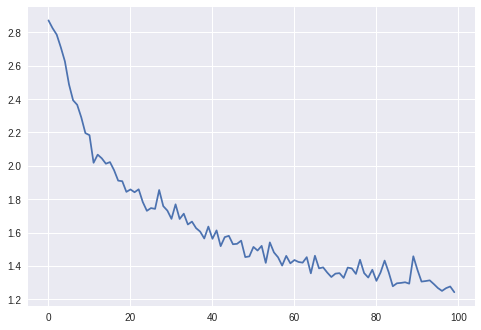

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

import matplotlib.style
import matplotlib as mpl
mpl.style.use('seaborn')

fig=plt.figure()
aaa = plt.plot(all_losses)

In [19]:
y = all_losses
n = 10
averages = []
for i in range(len(y) - n):
    window = y[i:i+n]
    avg = sum(window) / n
    # print(window, avg)
    averages.append(avg)

In [20]:
len(all_losses), len(averages)

(100, 90)

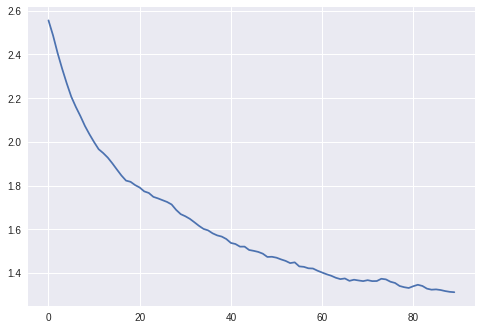

In [21]:
fig=plt.figure()
aaa = plt.plot(averages)

# Ocenianie Wyników

Aby sprawdzić jak dobrze sieć radzi sobie z różnymi kategoriami tworzymy macież zmieszania w której dla każdego języka (wiersz) pokazane są wynika predykcji (kolumny). Aby wyliczyć macierz zmieszania przez sieć przepuszczamy serię próbek przez funkcję  `evaluate()`, która robie to samo co  `train()` za wyjątkiem wstecznej propagacji.

In [22]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_pair()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1
    
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

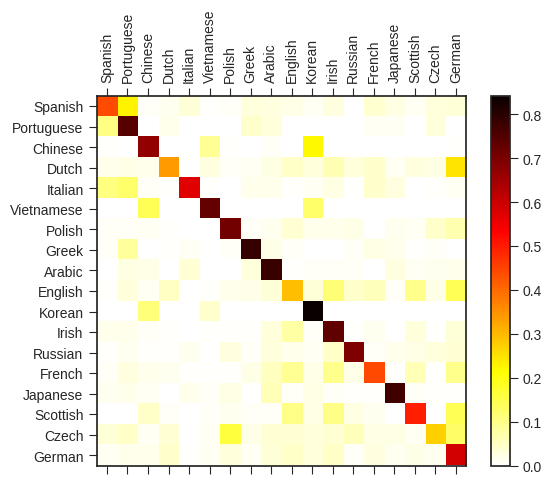

In [23]:
mpl.style.use('default')
mpl.style.use('seaborn-ticks')

mpl.pyplot.set_cmap('hot_r')

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

Można wybrać jasne kwadraciki na wykresie aby zobaczyć które przewidywania nie są prawidłowe.


# Running on User Input

In [24]:
import numpy as np

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(line_to_tensor(input_line)))

    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        pred = np.exp(value)
        print('(%.2f%%) %s' % (pred*100, all_categories[category_index]))
        # print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Czarnowski')
predict('Kazimierczak')
predict('Wołk')


> Dovesky
(59.43%) Russian
(27.79%) Czech
(5.13%) Polish

> Jackson
(79.99%) Scottish
(9.67%) English
(4.73%) Russian

> Satoshi
(47.51%) Japanese
(26.99%) Arabic
(10.29%) Polish

> Czarnowski
(79.13%) Polish
(6.21%) Russian
(6.04%) Czech

> Kazimierczak
(98.97%) Polish
(0.73%) Czech
(0.14%) Russian

> Wołk
(52.46%) Korean
(17.54%) Czech
(4.57%) Polish


# Ćwiczenia

* Wypróbuj inny zbiór danych typu wartość -> kategoria, np.:
    * słowo -> język
    * imię -> gender
    * bohater -> pisarz
   
* Popraw wyniki tworząc większą sieć lub sieć o lepszej struktórze
    * Więcej warstw
    * Wypróbuj `nn.LSTM` oraz `nn.GRU` 
    * Połacz wiele wartw oraz optymalizatorów w hierarchi

# 